# 0. Import Inicial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 1. Flipping Image

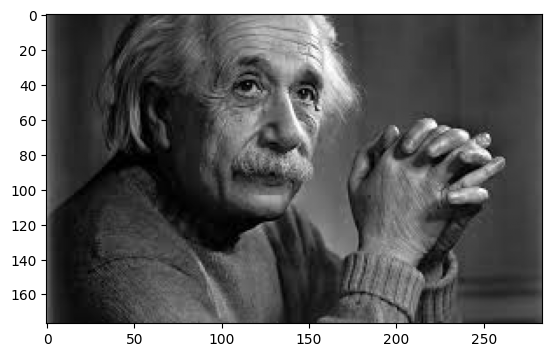

In [28]:
im = cv2.imread(r'einstein_PB.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(im,cmap='gray')

In [29]:
I_gray = im.copy()
numRows = I_gray.shape[0]
numCols = I_gray.shape[1]

I_gray2 = np.zeros((numRows,numCols),dtype='uint8')

for i in range(numRows):
    for j in range(numCols):
        I_gray2[i,j] = I_gray[i,j]

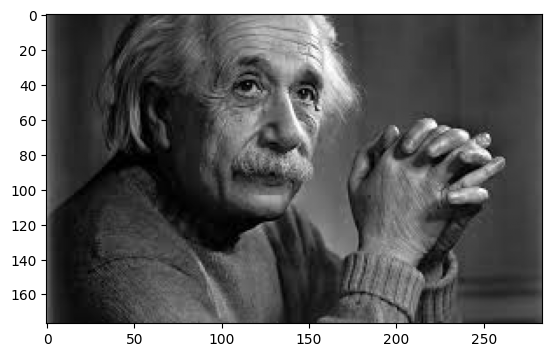

In [32]:
plt.imshow(I_gray2,cmap='gray')

In [33]:
I_gray = im.copy()
numRows = I_gray.shape[0]
numCols = I_gray.shape[1]

I_gray2 = np.zeros((numRows,numCols),dtype='uint8')

for i in range(numRows):
    for j in range(numCols):
        I_gray2[numRows-i-1,j] = I_gray[i,j]

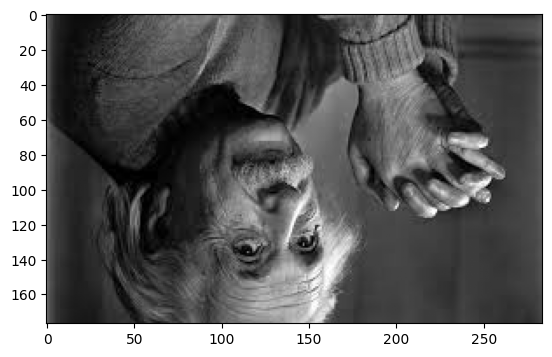

In [34]:
plt.imshow(I_gray2,cmap='gray')

# 2. Cropping Image

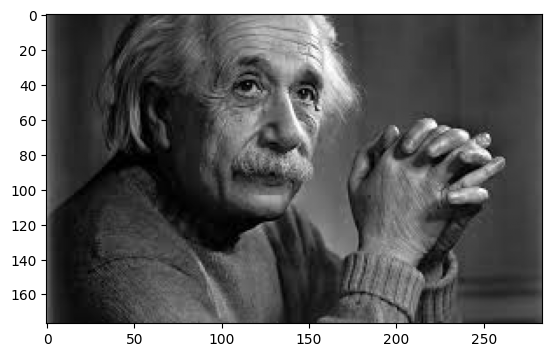

In [35]:
im = cv2.imread(r'einstein_PB.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(im,cmap='gray')

In [39]:
I_gray = im.copy()
numRows = int(round(I_gray.shape[0]/2,0))
numCols = I_gray.shape[1]

I_gray2 = np.zeros((numRows,numCols),dtype='uint8')

for i in range(numRows):
    for j in range(numCols):
        I_gray2[i,j] = I_gray[i,j]

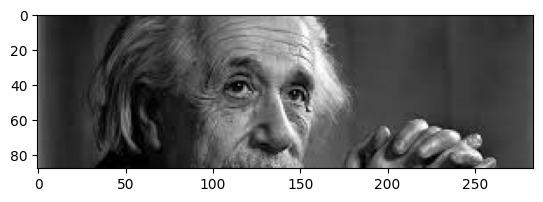

In [40]:
plt.imshow(I_gray2,cmap='gray')

 # 3. Scaling with Interpolation (Nearest Neighbour)

In [47]:
S = np.array([[2,0],[0,2]])
I2 = np.zeros((2*numRows, 2*numCols),dtype='uint8')
Tinv = np.linalg.inv(S)
for new_i in range(I2.shape[0]):
    for new_j in range(I2.shape[1 ]):
        P_dash = np.array([new_i,new_j])
        P = Tinv.dot(P_dash)
        P = np.int16(np.floor(P))
        i , j = P[0],P[1]
        I2[new_i,new_j] = I_gray[i,j]

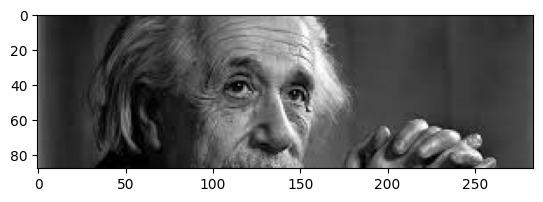

In [49]:
plt.imshow(I_gray2,cmap='gray')

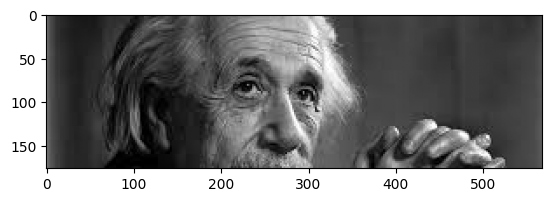

In [48]:
plt.imshow(I2,cmap='gray')

 # 4. Bilinear Interpolation

In [54]:
def f_bilinearInterpolation(r,c,I):
    #lc =left column
    lc = int(c)
    #rc = right column
    rc = lc + 1
    wr = c - lc
    wl = rc - c
    #tr = top row
    tr = int(r)
    #br = bottom row
    br = tr+1
    wt = br - r
    wb = r - tr
    if tr>= 0 and br< I.shape[0] and lc >= 0 and rc < I.shape[1]:
        a = (wl*I[tr,lc]) + (wr*I[tr,rc])
        b = (wl*I[br,lc]) + (wr*I[br,rc])

        g = (wt*a) + (wb*b)
        return np.uint8(g)
    else:
        return 0 
    

In [55]:
S = np.array([[2,0],[0,2]])
I2 = np.zeros((2*numRows, 2*numCols),dtype='uint8')
Tinv = np.linalg.inv(S)
for new_i in range(I2.shape[0]):
    for new_j in range(I2.shape[1 ]):
        P_dash = np.array([new_i,new_j])
        P = Tinv.dot(P_dash)
        #P = np.int16(np.floor(P))
        i , j = P[0],P[1]
        if i < 0 or i>=numRows or j<0 or j>=numCols:
            pass
        else:
            g = f_bilinearInterpolation(i, j, I_gray2)
            I2[new_i,new_j] = g

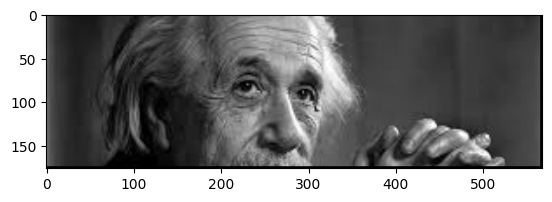

In [56]:
plt.imshow(I2,cmap='gray')

# 5. Rotation

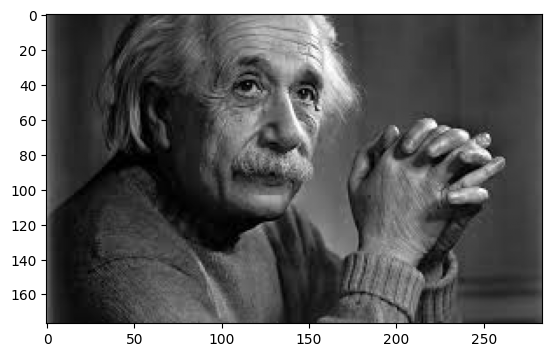

In [65]:
im = cv2.imread(r'einstein_PB.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(im,cmap='gray')
I_gray = im.copy()

numRows = I_gray.shape[0]
numCols = I_gray.shape[1]

a = 45
cosa = np.cos(np.deg2rad(a))
sina = np.cos(np.deg2rad(a))
R = np.array([[cosa,-sina],[sina,cosa]])

In [66]:
rMax, cMax = I_gray.shape[0], I_gray.shape[1]
coords = np.array([[0,0],[0,cMax-1],[rMax-1,0],[rMax-1, cMax-1]])
A_dash = R.dot(coords.T)
mins = A_dash.min(axis=1)
maxs = A_dash.max(axis=1)
minR = np.int64(np.floor(mins[0]))
minC = np.int64(np.floor(mins[1]))
maxR = np.int64(np.ceil(maxs[0]))
maxC = np.int64(np.ceil(maxs[1]))
H,W = maxR-minR+1 , maxC-minC+1
I2 = np.zeros((H,W),dtype='uint8')

Tinv = np.linalg.inv(R)
for new_i in range(minR, maxR):
    for new_j in range(minC,maxC):
        P_dash = np.array([new_i,new_j])
        P = Tinv.dot(P_dash)
        i , j = P[0],P[1]
        if i < 0 or i>=numRows or j<0 or j>=numCols:
            pass
        else:
            g = f_bilinearInterpolation(i, j, I_gray)
            I2[new_i-minR,new_j-minC] = g

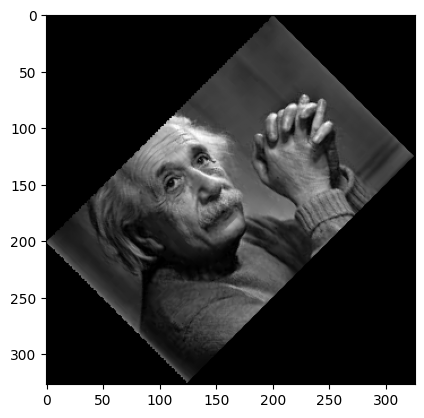

In [67]:
plt.imshow(I2,cmap='gray')

# 6. Generalized Transformation

In [69]:
def f_getExtents(T,rMax,cMax):
    coords = np.array([[0,0],[0,cMax-1],[rMax-1,0],[rMax-1, cMax-1]])
    A_dash = T.dot(coords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H,W = maxR-minR+1 , maxC-minC+1
    return minR, minC, maxR,minR,H,W

In [70]:
def f_transform(T, I_gray):
    rMax, cMax = I_gray.shape[0], I_gray.shape[1]
    minR, minC, maxR,minR,H,W = f_getExtents(T, rMax, cMax)
    I2 = np.zeros((H,W),dtype='uint8')

    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC,maxC):
            P_dash = np.array([new_i,new_j])
            P = Tinv.dot(P_dash)
            i , j = P[0],P[1]
            if i < 0 or i>=numRows or j<0 or j>=numCols:
                pass
            else:
                g = f_bilinearInterpolation(i, j, I_gray)
                I2[new_i-minR,new_j-minC] = g
    return I2

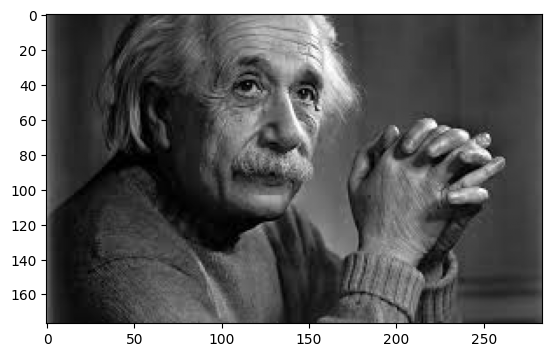

In [73]:
im = cv2.imread(r'einstein_PB.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(im,cmap='gray')
I_gray = im.copy()

numRows = I_gray.shape[0]
numCols = I_gray.shape[1]

a = 45
cosa = np.cos(np.deg2rad(a))
sina = np.cos(np.deg2rad(a))
R = np.array([[cosa,-sina],[sina,cosa]])

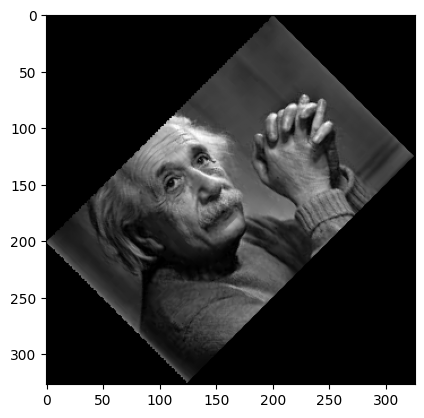

In [74]:
I2 = f_transform(R,I_gray)
plt.imshow(I2,cmap='gray')

# 7. Rotation with OpenCV

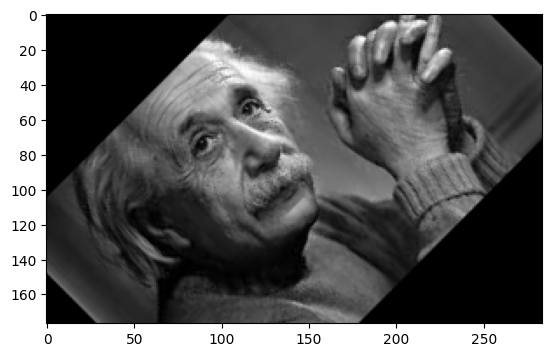

In [75]:
im = cv2.imread(r'einstein_PB.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(im,cmap='gray')
I_gray = im.copy()

a = 45
scale = 1.0
image_center =  tuple(np.array(I_gray.shape[1::-1])/2)

rot_mat = cv2.getRotationMatrix2D(image_center,a,scale)
i = cv2.warpAffine(I_gray, rot_mat, I_gray.shape[::-1])
plt.imshow(i,cmap='gray')

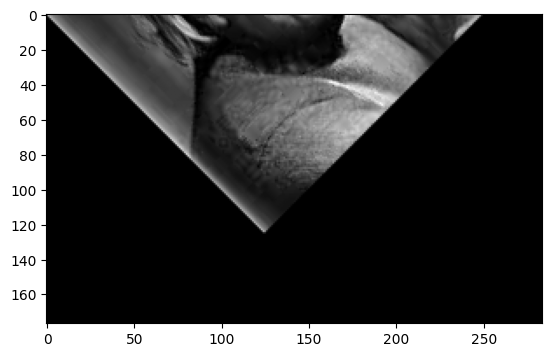

In [76]:
im = cv2.imread(r'einstein_PB.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(im,cmap='gray')
I_gray = im.copy()

a = 45
scale = 1.0
image_center =  tuple(np.array(I_gray.shape[1::-1])/2)

rot_mat = cv2.getRotationMatrix2D((0,0),a,scale)
i = cv2.warpAffine(I_gray, rot_mat, I_gray.shape[::-1])
plt.imshow(i,cmap='gray')